In [1]:
%pylab inline

from joblib import Memory
import xarray as xr
from lib import SamRun
import gnl.xcalc
import seaborn as sns
import pandas as pd


mem = Memory("wd/mem/")

run = SamRun("8aa7b", root="/scratch/ndb245/Data/SAM6.10.9/JOBS")

Populating the interactive namespace from numpy and matplotlib


The goal of this notebook is to see if the vertical derivative of partial pressure is similar to the bouyancy field given by $B=\delta T_v/ T_{v0}$.

Open the partial pressure field

In [2]:
full = xr.open_dataset(run.data3d[-1]).isel(time=slice(-3,None)).sel(z=slice(0,10e3)).compute()
pp = full.PP.coarsen(x=8).compute()

stats = xr.open_dataset(run.stats[0], cache=False)
rho = stats.RHO[0].compute()

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/chunk.py:148: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)))


Compute the bouyancy using the virtual potential temperature formulation.

In [3]:
tv = full.TABS * (1 + .61 * full.QV/1000)
tv0 = tv.mean('x')
B = (tv - tv0)/tv0 * 9.81
B = B.coarsen(x=8).compute()

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/chunk.py:148: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)))


Vertical derivative of the partial pressure. If the solution is hydrostatic, this should be equal to the bouyancy.

In [4]:
pp_z = pp.centderiv('z', boundary='extrap').compute()

In [5]:
def corr(x, y):
    return x.dot(y) /np.sqrt(x.dot(x) * y.dot(y))

pp_zx = pp_z.centderiv('x')
b_x = B.centderiv('x')

corr(pp_zx.compute(), b_x.compute())

<xarray.DataArray ()>
array(0.8736333250999451, dtype=float32)

The correlation between the $p_zx$ and $b_x$ is only .78, which is not as high as I would like. Is this difference due to 

1. an incorrect calculation of the bouyancy variable, or
2. an error in the vertical derivative of $p'$,
2. non-hydrostatic effects?

Let's compare a plot of the two fields:

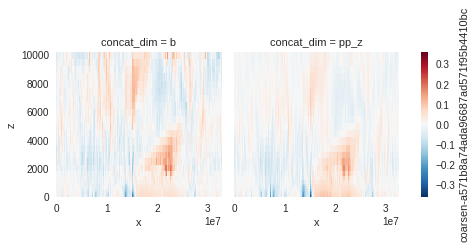

In [6]:
import pandas as pd

pd.Index(['b_x', 'pp_zx'])

xr.concat([B-B.mean('x'), pp_z-pp_z.mean('x')], dim=pd.Index(['b', 'pp_z']))\
.sel(z=slice(0,10e3))\
.isel(time=-2)\
.plot(col='concat_dim')

Here, we can see again that the vertical gradient of the partial pressure is close to the bouyance field, but is smaller in magnitude. Maybe we should perform the analysis using the $B= p'_z$ instead of the virtual temperature formulation when analyzing the horizontal momentum equation.

## Non-hydrostatic effects

Here we look at the non-hydrostatic effects

In [7]:
dwdt = (full.U * full.W.centderiv('x') + full.W * full.W.centderiv('z', boundary='extrap')
        + full.W.centderiv('time', boundary='extrap'))/86400
dwdt = dwdt.coarsen(x=8).isel(time=-1).compute()

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/chunk.py:148: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)))


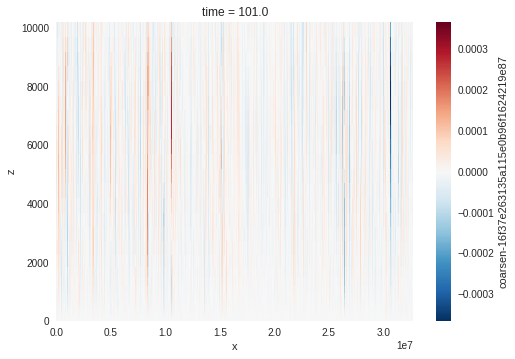

In [8]:
dwdt.sel(z=slice(0,10e3)).plot()

Clearly the non-hydrostatic effects are not important here.

## Integrating the full hydrostatic balance condition

$$ \frac{d \log p}{dz} = -\frac{g}{R_d T_v}$$

In [9]:
p = np.exp(-(9.81 / 287 /  tv).cumtrapz('z')+log(1015e2))
dpdz = -9.81/287 *p/tv
dpdz -= dpdz.mean('x')
dpdz = dpdz.coarsen(x=8).compute()

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/chunk.py:148: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)))


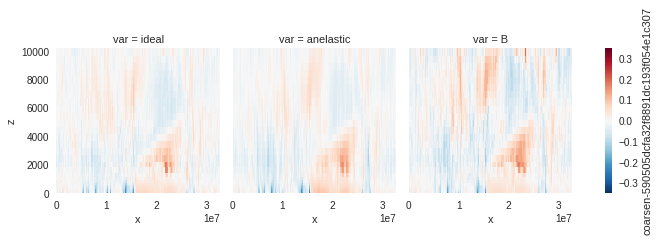

In [10]:
comparison = xr.concat([dpdz, pp_z-pp_z.mean('x'), B], dim=pd.Index(['ideal', 'anelastic', 'B'], name='var'))\
.isel(time=0)
comparison.plot(col='var')

These results are very similar to B

In [11]:
df = comparison\
.to_dataset('var')\
.to_dataframe()\
.drop('time',axis=1)
df.head()

ideal  anelastic         B
x      z                                        
7000.0 37.500000   0.005477  -0.001808  0.004322
       112.500000  0.008740  -0.001437  0.007165
       194.039993  0.006402  -0.002413  0.005362
       288.079987  0.003046  -0.005507  0.002573
       395.369995 -0.001458  -0.009736 -0.001172

In [12]:
def plot_pair(x,y,df,ax=None):

    ax = df.plot.scatter(x, y, alpha=.01, rasterized=True, ax=ax)
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    return ax

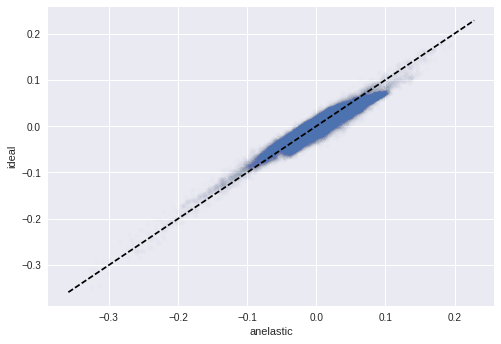

In [13]:
plot_pair('anelastic', 'ideal', df)

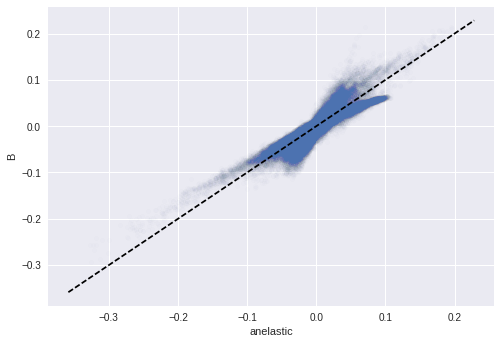

In [14]:
plot_pair('anelastic', 'B', df)

## Dividing $p'$ by $\rho$



In [15]:
dpdz= (pp/rho)\
.centderiv('z', boundary='extrap').compute()

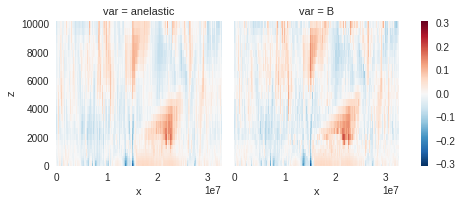

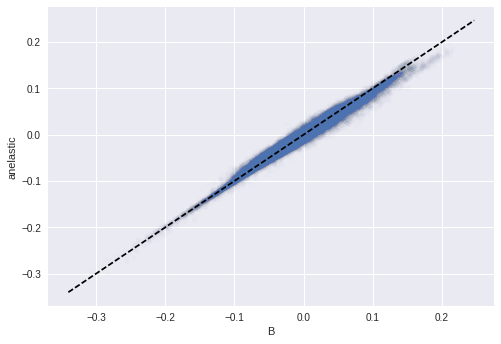

In [16]:
def compare_b_pz(dpdz, B):
    
    comparison = xr.concat([dpdz - dpdz.mean('x'), B-B.mean('x')], dim=pd.Index(['anelastic', 'B'], name='var'))
    comparison.isel(time=1).plot(col='var')

    df = comparison.to_dataset('var').to_dataframe()
    plot_pair('B', 'anelastic', df)

    return comparison, df


comparison, df= compare_b_pz(dpdz, B)

The relationship is nearly 1-1 here.

This analysis shows that $B$ is an appropriate variable for computing the hydrostatic pressure gradient. This however, does analysis does not indicate whether using the same reference density profile for all time steps is works. Let's compute B this way instead.

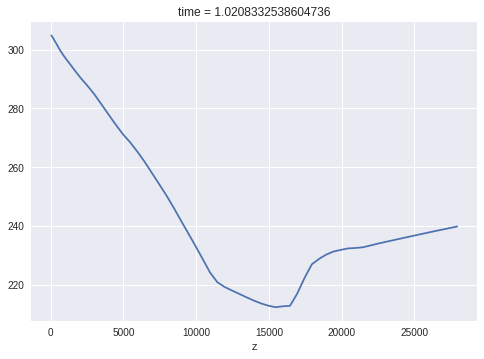

In [17]:
tv0 = stats.p*100/rho/287

tv0.plot()

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/chunk.py:148: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)))


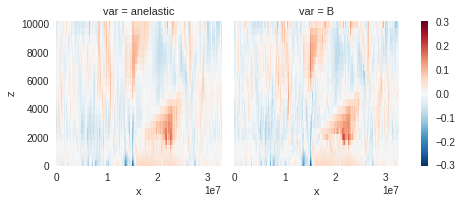

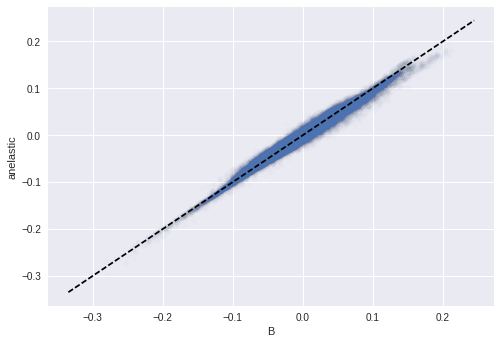

In [18]:
B = (tv-tv0)*9.81/tv0
B = B.coarsen(x=8).compute()
compare_b_pz(dpdz, B);

These results do not depend strongly on the base profile being used.

## Water loading effect

The full expression for virtual potential temperature is given by
$$T_v = T \frac{1+r_v \frac{R_v}{R_d}}{1 + r_v + r_c}.$$
Assuming that the mixing ratios of water compared to dry air are small, then the virtual temperature can be written as
$$T_v\approx T \left[1 + r_v \left(\frac{R_v}{R_d}-1 \right) - r_c\right].$$
Using the metpy library, we can find the ratio of the gas constants.

In [29]:
from metpy.constants import Rv, Rd
rvcoef = float(Rv/Rd - 1)
rvcoef

0.6077685165037681

Therefore, a suitable formula for virtual temperature is given by
\begin{equation}
T_v\approx T \left[1 + 0.6078 r_v - r_c\right].
\end{equation}

Here is the comparison plot using this data:

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/chunk.py:148: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)))


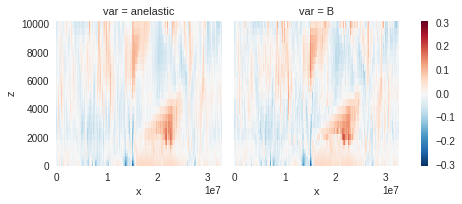

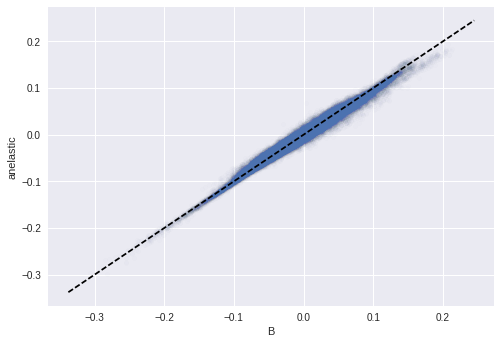

In [43]:

dpdz = (pp/rho).centderiv('z', 'extrap')
dpdz = dpdz.compute()
tv = full.TABS * (1 + rvcoef * full.QV/1e3 - full.QP/1e3 - full.QN/1e3)
tv = tv.coarsen(x=8).compute()

B = (tv-tv0)/tv0 * 9.81


compare_b_pz(dpdz, B);

The difference is pretty small. The differences are probably to non-hydrostatic effects and the difference between the simple centered differences used here and the schemes differentiation used in SAM's pressure solver.